In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor
import shap

import warnings
warnings.filterwarnings('ignore')

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# Load dataset
df = pd.read_csv('house_prices_srilanka.csv')

print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (20000, 14)


,district,area,perch,bedrooms,bathrooms,kitchen_area_sqft,parking_spots,has_garden,has_ac,water_supply,electricity,floors,year_built,price_lkr
0,Polonnaruwa,Polonnaruwa Central,14,5,4,112,2,False,False,Pipe-borne,Single phase,1,2022,16236332
1,Matale,Matale Central,26,7,5,250,2,True,False,Both,Single phase,3,1987,33907509
2,Mullaitivu,Mullaitivu Central,7,3,2,77,2,True,True,Well,Single phase,1,1988,5954312
3,Anuradhapura,New Town,2,2,2,39,1,True,True,Both,Three phase,2,2024,5177534
4,Batticaloa,Batticaloa Town,20,5,4,117,1,True,True,Well,Single phase,1,1995,20182409


In [3]:
# Basic statistics
df.describe()

,perch,bedrooms,bathrooms,kitchen_area_sqft,parking_spots,floors,year_built,price_lkr
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,2.000000e+04
mean,11.510500,3.901600,3.171650,113.718800,1.141100,1.557150,2004.926550,1.598142e+07
std,8.519719,1.839426,1.530883,69.801873,0.939167,0.628135,11.817353,1.338156e+07
min,2.000000,1.000000,1.000000,35.000000,0.000000,1.000000,1985.000000,1.500000e+06
25%,5.000000,2.000000,2.000000,53.000000,0.000000,1.000000,1995.000000,6.591047e+06
50%,10.000000,4.000000,3.000000,95.000000,1.000000,1.000000,2005.000000,1.206384e+07
75%,16.000000,5.000000,5.000000,161.000000,2.000000,2.000000,2015.000000,2.096723e+07
max,80.000000,7.000000,5.000000,250.000000,3.000000,3.000000,2025.000000,1.500321e+08


In [4]:
# Check null values
print('Missing values per column:')
print(df.isnull().sum())
print(f'\nTotal missing: {df.isnull().sum().sum()}')

Missing values per column:
district             0
area                 0
perch                0
bedrooms             0
bathrooms            0
kitchen_area_sqft    0
parking_spots        0
has_garden           0
has_ac               0
water_supply         0
electricity          0
floors               0
year_built           0
price_lkr            0
dtype: int64

Total missing: 0


In [5]:
# Check dtypes
print('Column data types:')
print(df.dtypes)

Column data types:
district             object
area                 object
perch                 int64
bedrooms              int64
bathrooms             int64
kitchen_area_sqft     int64
parking_spots         int64
has_garden             bool
has_ac                 bool
water_supply         object
electricity          object
floors                int64
year_built            int64
price_lkr             int64
dtype: object


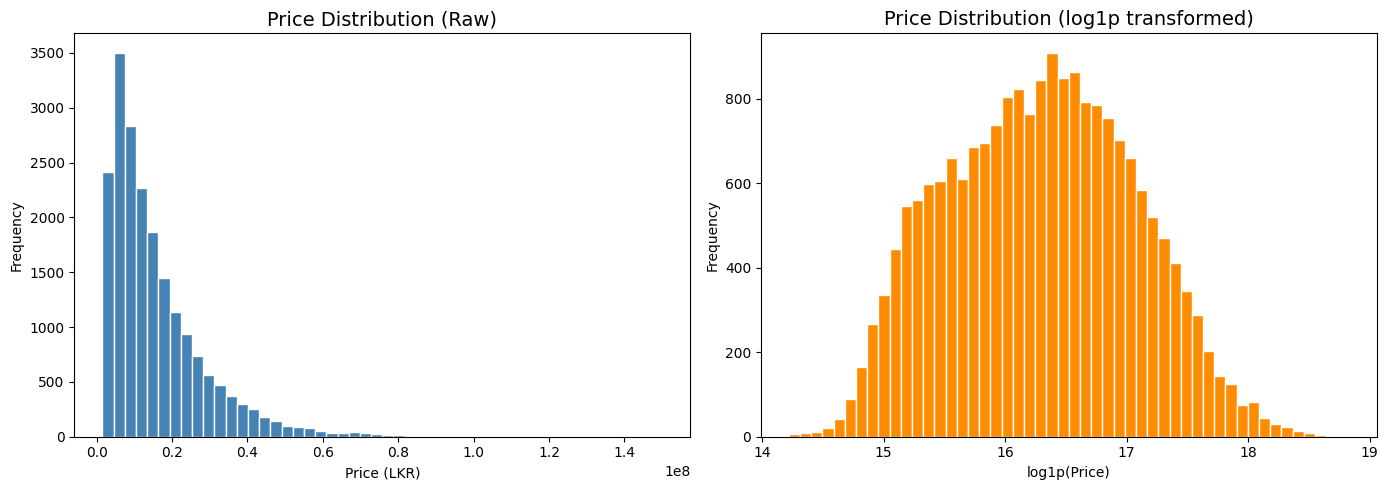

In [6]:
# Target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw price
axes[0].hist(df['price_lkr'], bins=50, color='steelblue', edgecolor='white')
axes[0].set_title('Price Distribution (Raw)', fontsize=14)
axes[0].set_xlabel('Price (LKR)')
axes[0].set_ylabel('Frequency')

# Log-transformed price
axes[1].hist(np.log1p(df['price_lkr']), bins=50, color='darkorange', edgecolor='white')
axes[1].set_title('Price Distribution (log1p transformed)', fontsize=14)
axes[1].set_xlabel('log1p(Price)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Note: Price is right-skewed. Using log1p transformation improves model accuracy.

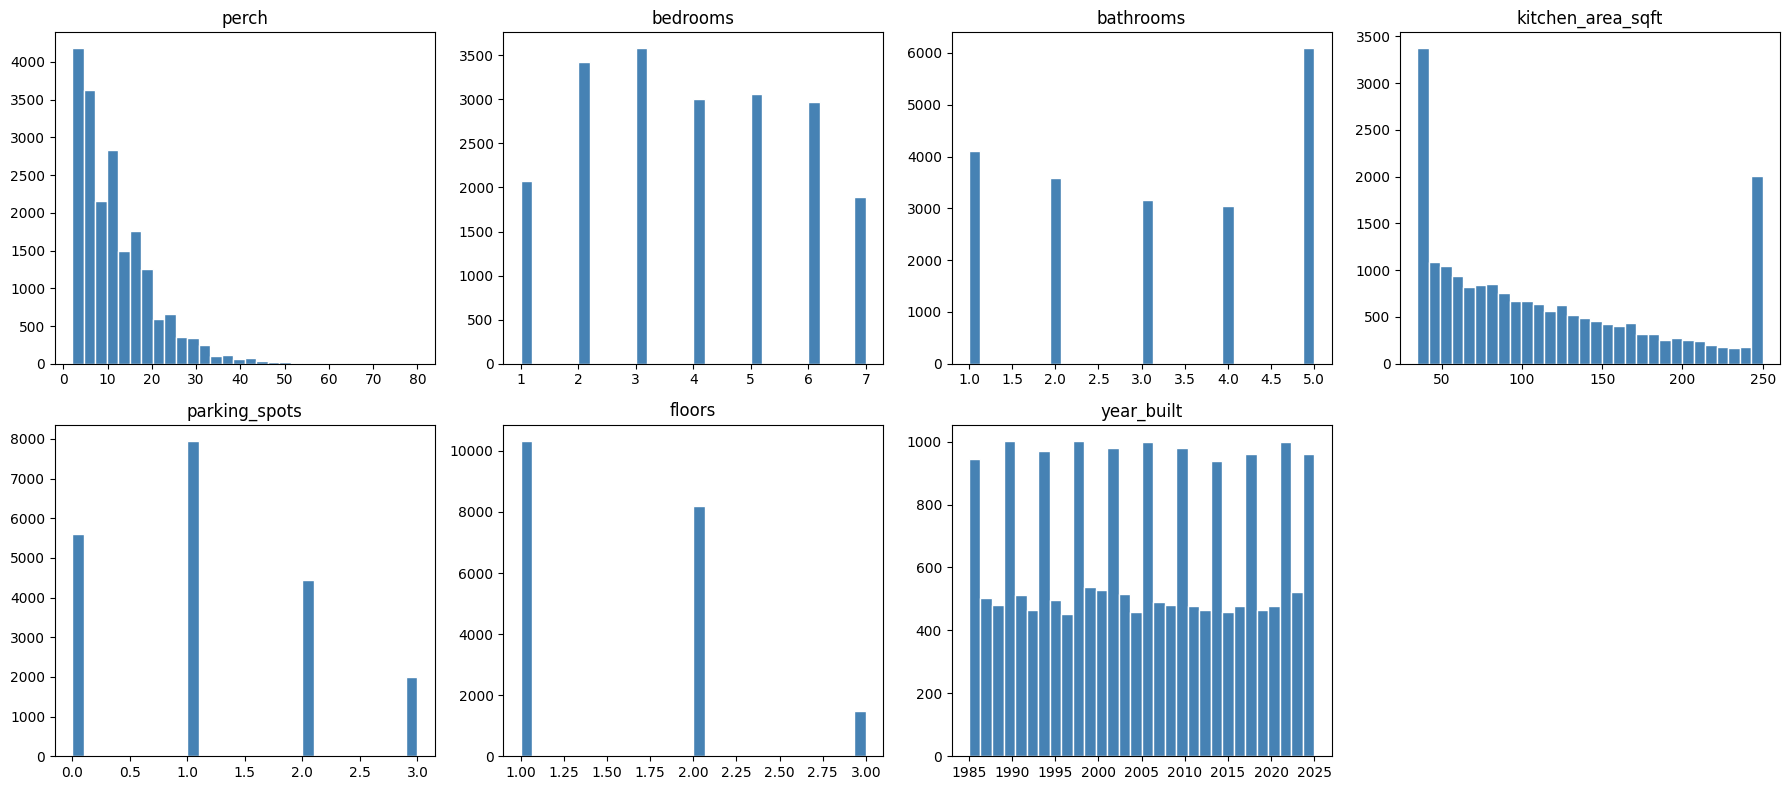

In [7]:
# Numerical features distribution
num_cols = ['perch', 'bedrooms', 'bathrooms', 'kitchen_area_sqft', 'parking_spots', 'floors', 'year_built']

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].hist(df[col], bins=30, color='steelblue', edgecolor='white')
    axes[i].set_title(col, fontsize=12)

# Remove last unused subplot
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

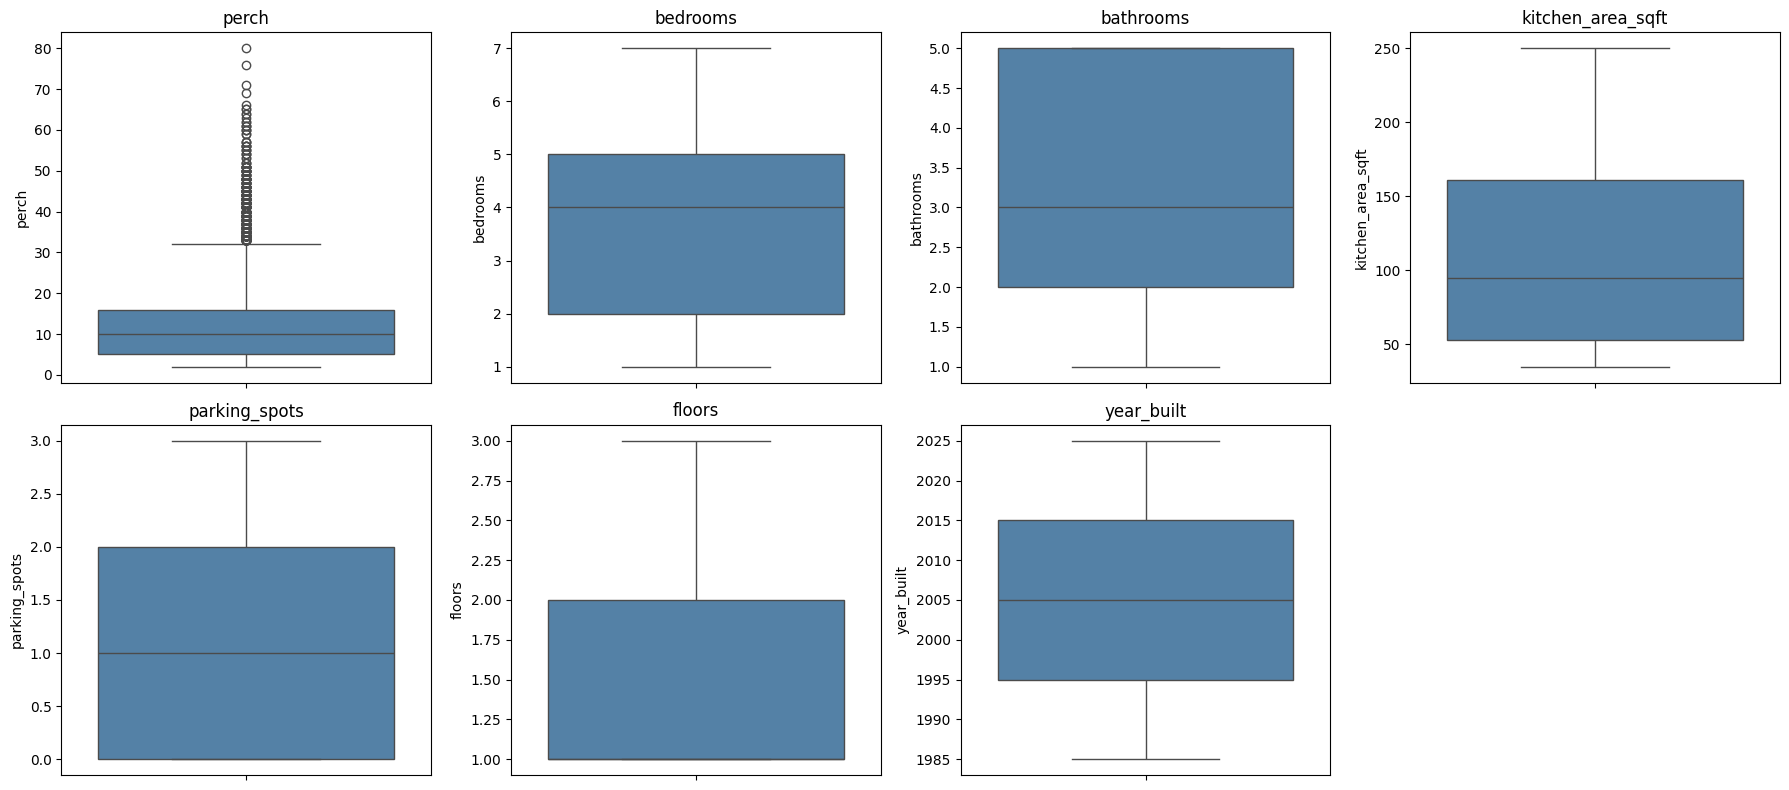

In [8]:
# Boxplots for outlier visualization
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(y=df[col], ax=axes[i], color='steelblue')
    axes[i].set_title(col, fontsize=12)

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

# Note: Large perch values = realistic large land sizes.
# Large price values = luxury houses. Both are REAL data, not errors.
# XGBoost is robust to these — no outlier removal needed.

In [9]:
# Categorical features
cat_cols = ['district', 'area', 'water_supply', 'electricity']

for col in cat_cols:
    print(f'{col}: {df[col].nunique()} unique values')
    print(df[col].value_counts().head(10))
    print()

district: 25 unique values
district
Polonnaruwa    845
Batticaloa     837
Badulla        834
Gampaha        825
Colombo        818
Hambantota     814
Kurunegala     810
Kegalle        810
Kandy          809
Monaragala     807
Name: count, dtype: int64

area: 69 unique values
area
Polonnaruwa Central    845
Kegalle Central        810
Ampara Central         807
Monaragala Central     807
Mannar Central         801
Puttalam Central       799
Kilinochchi Central    788
Matale Central         788
Vavuniya Central       782
Mullaitivu Central     781
Name: count, dtype: int64

water_supply: 3 unique values
water_supply
Both          6767
Pipe-borne    6697
Well          6536
Name: count, dtype: int64

electricity: 2 unique values
electricity
Single phase    10037
Three phase      9963
Name: count, dtype: int64



In [10]:
# Feature engineering: house_age
REF_YEAR = 2025
df['house_age'] = REF_YEAR - df['year_built']

# Convert boolean columns
df['has_garden'] = df['has_garden'].astype(int)
df['has_ac'] = df['has_ac'].astype(int)

print(f'New columns: house_age')
df[['year_built', 'house_age']].head()

New columns: house_age


,year_built,house_age
0,2022,3
1,1987,38
2,1988,37
3,2024,1
4,1995,30


In [11]:
# Define features and target
FEATURE_COLS = [
    'perch', 'bedrooms', 'bathrooms', 'kitchen_area_sqft', 'parking_spots',
    'has_garden', 'has_ac', 'floors', 'house_age',
    'district', 'area', 'water_supply', 'electricity'
]

X = df[FEATURE_COLS].copy()
y = df['price_lkr'].copy()

# Apply log1p transformation to target (handles right-skewness)
y_log = np.log1p(y)

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log,
    test_size=0.2,
    random_state=RANDOM_STATE
)

# Also keep original y_test for final evaluation (in actual LKR)
_, _, y_train_orig, y_test_orig = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print(f'Training samples  : {X_train.shape[0]:,}')
print(f'Test samples      : {X_test.shape[0]:,}')
print(f'Number of features: {X_train.shape[1]}')

Training samples  : 16,000
Test samples      : 4,000
Number of features: 13


In [12]:
# One-hot encoding for categorical variables
CAT_COLS = ['district', 'area', 'water_supply', 'electricity']

X_train_encoded = pd.get_dummies(X_train, columns=CAT_COLS, drop_first=False)
X_test_encoded  = pd.get_dummies(X_test,  columns=CAT_COLS, drop_first=False)

# Align columns (test may miss some dummies that appear in train)
X_train_encoded, X_test_encoded = X_train_encoded.align(
    X_test_encoded, join='left', axis=1, fill_value=0
)

print(f'Encoded training features : {X_train_encoded.shape[1]}')
print(f'Encoded test features     : {X_test_encoded.shape[1]}')
print('\nSample columns:')
print(list(X_train_encoded.columns[:10]))

Encoded training features : 108
Encoded test features     : 108

Sample columns:
['perch', 'bedrooms', 'bathrooms', 'kitchen_area_sqft', 'parking_spots', 'has_garden', 'has_ac', 'floors', 'house_age', 'district_Ampara']


In [13]:
# XGBoost Baseline
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    eval_metric='rmse'
)

# Early stopping to prevent overfitting
model.fit(
    X_train_encoded,
    y_train,
    eval_set=[(X_test_encoded, y_test)],
    # early_stopping_rounds=20,
    verbose=False
)

# Note: Early stopping functionality for the baseline model is disabled due to environment incompatibility.
# The best iteration will reflect the number of estimators if not stopped early by other means.
# If early stopping is crucial, consider manual implementation or environment upgrade.

print(f'Best iteration: {getattr(model, 'best_iteration', 'N/A - early stopping disabled')}')
print('Baseline model trained (without early stopping due to compatibility issues)')

Best iteration: N/A - early stopping disabled
Baseline model trained (without early stopping due to compatibility issues)


In [14]:

# Baseline evaluation
y_pred_log = model.predict(X_test_encoded)
y_pred = np.expm1(y_pred_log)   # Inverse log transform

rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
mae  = mean_absolute_error(y_test_orig, y_pred)
r2   = r2_score(y_test_orig, y_pred)

print('Baseline Model Performance:')
print(f'  RMSE : {rmse:,.0f} LKR')
print(f'  MAE  : {mae:,.0f} LKR')
print(f'  R²   : {r2:.4f}')

Baseline Model Performance:
  RMSE : 2,396,102 LKR
  MAE  : 1,593,238 LKR
  R²   : 0.9677


In [15]:
# Hyperparameter grid
param_dist = {
    'n_estimators'    : [100, 200, 300, 500],
    'learning_rate'   : [0.01, 0.05, 0.1, 0.2],
    'max_depth'       : [3, 4, 5, 6, 7],
    'subsample'       : [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma'           : [0, 0.1, 0.2, 0.3]
}

# Base estimator for search
xgb_base = XGBRegressor(
    random_state=RANDOM_STATE,
    eval_metric='rmse'
)

# RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

search.fit(X_train_encoded, y_train)

print(f'Best params: {search.best_params_}')
print(f'Best CV RMSE (log scale): {-search.best_score_:.4f}')

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best CV RMSE (log scale): 0.1348


In [16]:
# Use best_model (search.best_estimator_) for predictions
best_model = search.best_estimator_

print('Best model parameters:')
for k, v in search.best_params_.items():
    print(f'  {k}: {v}')

Best model parameters:
  subsample: 0.7
  n_estimators: 500
  min_child_weight: 3
  max_depth: 4
  learning_rate: 0.05
  gamma: 0.1
  colsample_bytree: 0.7


In [17]:
# Predict with best_model (tuned model), not old baseline model
y_pred_log = best_model.predict(X_test_encoded)

# Inverse log transform to get actual LKR prices
y_pred = np.expm1(y_pred_log)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
mae  = mean_absolute_error(y_test_orig, y_pred)
r2   = r2_score(y_test_orig, y_pred)

print('Best Model Performance (on Test Set):')
print(f'  RMSE : {rmse:,.0f} LKR')
print(f'  MAE  : {mae:,.0f} LKR')
print(f'  R²   : {r2:.4f}')

Best Model Performance (on Test Set):
  RMSE : 2,397,338 LKR
  MAE  : 1,580,239 LKR
  R²   : 0.9677


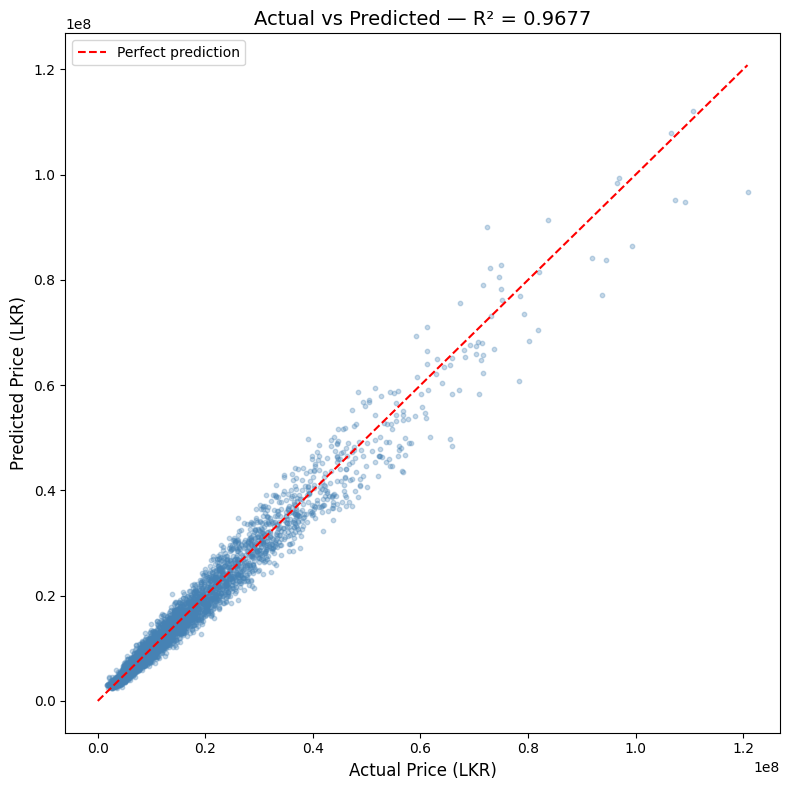

In [18]:
# Prediction vs Actual plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test_orig, y_pred, alpha=0.3, color='steelblue', s=10)
max_val = max(y_test_orig.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=1.5, label='Perfect prediction')
plt.xlabel('Actual Price (LKR)', fontsize=12)
plt.ylabel('Predicted Price (LKR)', fontsize=12)
plt.title(f'Actual vs Predicted — R² = {r2:.4f}', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

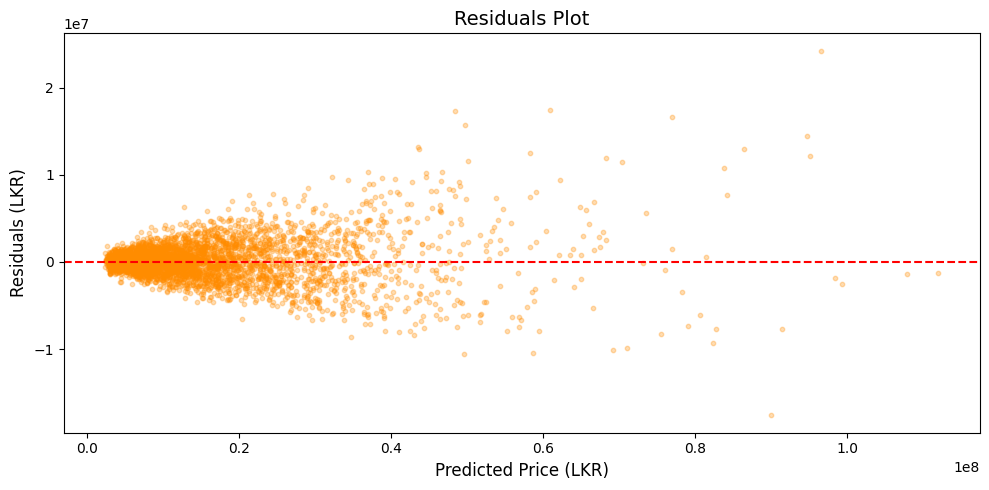

In [19]:
# Residuals plot
residuals = y_test_orig.values - y_pred

plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.3, color='darkorange', s=10)
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Predicted Price (LKR)', fontsize=12)
plt.ylabel('Residuals (LKR)', fontsize=12)
plt.title('Residuals Plot', fontsize=14)
plt.tight_layout()
plt.show()

In [20]:
# Using best_model (already correct in original)
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test_encoded)

print('SHAP explainer created')

SHAP explainer created


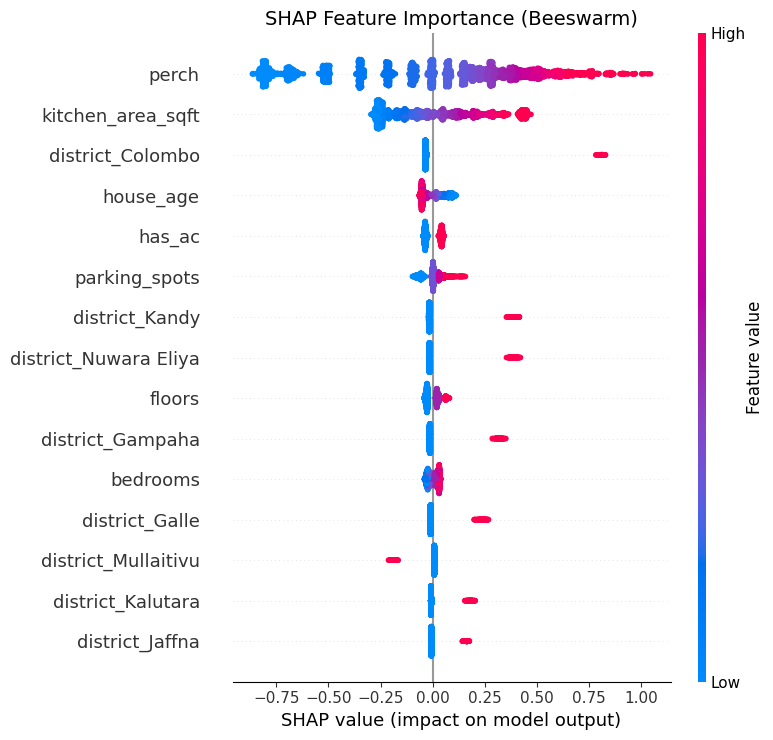

In [21]:
# SHAP summary plot — beeswarm
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_encoded, max_display=15, show=False)
plt.title('SHAP Feature Importance (Beeswarm)', fontsize=14)
plt.tight_layout()
plt.show()

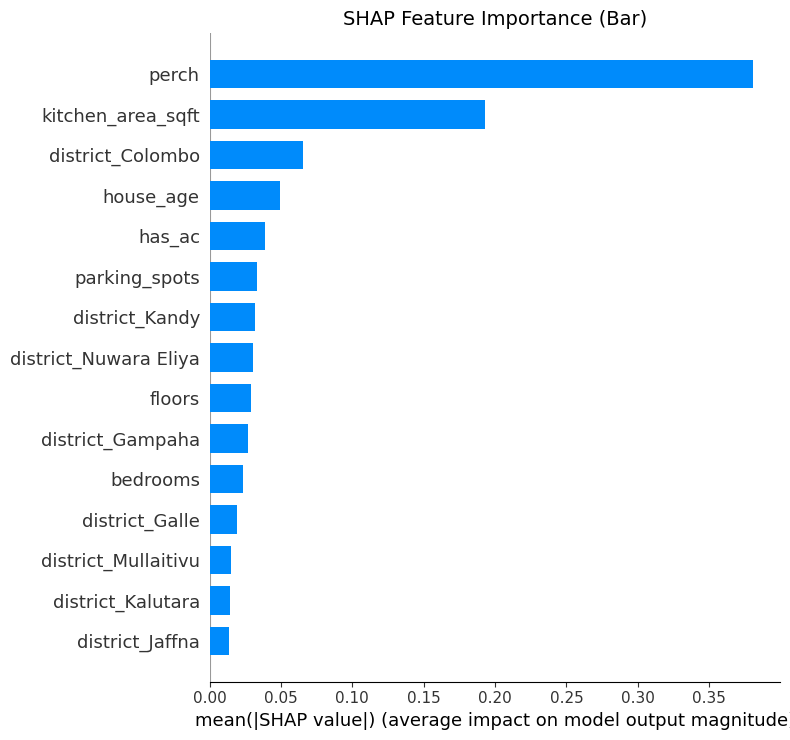

In [22]:
# SHAP bar plot — mean absolute SHAP values
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_encoded, plot_type='bar', max_display=15, show=False)
plt.title('SHAP Feature Importance (Bar)', fontsize=14)
plt.tight_layout()
plt.show()

In [23]:
# Save the best model as JSON (for deployment with FastAPI backend)
best_model.save_model('house_price_model.json')
print('Model saved to house_price_model.json')

Model saved to house_price_model.json
